<a href="https://colab.research.google.com/github/bcdanl/210-code/blob/main/danl_proj_nba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: Data Analysis Project
subtitle: Yahoo Finance Analysis
author: Ryan Horn
date: 2024-02-15
from: markdown+emoji
---

# Unifying ESG Metrics with Financial Analysis

## 1. Introduction

### Background
Over the past decade, investors and regulators have increasingly emphasized Environmental, Social, and Governance (ESG) performance as a key indicator of a company’s long-term resilience and ethical standing. At the same time, traditional financial metrics—like revenue growth, profit margins, and stock returns—remain the bedrock of investment decisions. Understanding how ESG risk scores evolve over time and how they relate to core financial performance can help firms balance sustainable practices with shareholder value.

### Problem Statement
This project examines whether a company’s ESG risk score is associated with its financial health. By combining ESG metrics and finance data, we aim to identify patterns that could guide more informed, sustainability-aware investment strategies.

---

## 2. Data Collection

*Data for both ESG risk scores and historical stock market data were retrieved using a standalone Python Selenium script (submitted separately to Brightspace).*

The script performs the following steps:

- Opens a headless browser, navigates to Yahoo Finance ESG pages for each ticker, and scrapes Total ESG, Environmental, Social, Governance scores, and Controversy level.  
- Navigates historical data pages (Jan 1 2024–Mar 31 2025) for each ticker and scrapes daily OHLCV.  
- Saves to `danl_210_HORN_RYAN_ESG.csv` and `danl_210_HORN_RYAN_stock.csv` locally.

---


## 3. Data Loading & Cleaning

---


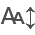

Symbol                 object
Name                   object
Year                    int64
Total_ESG_Risk        float64
Environmental_Risk    float64
Social_Risk           float64
Governance_Risk       float64
Controversy           float64
dtype: object
Symbol        object
Name          object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
Dividend     float64
Year           int64
Return       float64
dtype: object


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive= False)

# Load saved CSVs
esg_df   = pd.read_csv('/Users/ryanm/Documents/Classes/DANL Files/Spyder_work/Project_folder/danl_210_HORN_RYAN_ESG.csv')
stock_df = pd.read_csv('/Users/ryanm/Documents/Classes/DANL Files/Spyder_work/Project_folder/danl_210_HORN_RYAN_stock.csv')

show(esg_df)
show(stock_df)

# Compute daily returns
stock_df['Return'] = stock_df['Close'].pct_change()

# Quick peek at data types
print(esg_df.dtypes)
print(stock_df.dtypes)

# Drop rows missing key ESG values
esg_df = esg_df.dropna(subset=['Total_ESG_Risk'])

# Aggregate
avg_esg    = esg_df.groupby('Symbol')['Total_ESG_Risk'].mean().reset_index()
avg_return = stock_df.groupby('Symbol')['Return'].mean().reset_index()
company_df = pd.merge(avg_esg, avg_return, on='Symbol')



## 4. Descriptive Statistics


In [8]:
# ——— Ungrouped (overall) Descriptive Statistics ———

# ESG metrics
esg_overall = esg_df[['Total_ESG_Risk',
                      'Environmental_Risk',
                      'Social_Risk',
                      'Governance_Risk',
                      'Controversy']].describe()

# Stock metrics
stock_overall = stock_df[['Close', 'Volume', 'Return']].describe()

print("=== ESG Overall Summary ===")
show(esg_overall)
print("\n=== Stock Overall Summary ===")
show(stock_overall)


=== ESG Overall Summary ===



=== Stock Overall Summary ===


### 4.1 Ungrouped Summaries

*Interpretation:* 

*ESG Metrics*:

Total ESG Risk sits, on average, in the mid-teens to low-twenties, with a median very close to the mean—so most companies cluster around that moderate-risk level. The 25th–75th interquartile range tells you that half of firms fall within a relatively narrow band, but the full min-to-max span shows a handful of very low-risk and very high-risk outliers.

Environmental Risk has a similar right-skewed shape: most firms score low but a minority pull the average up.

Social Risk is more tightly centered (smaller IQR), suggesting social issues vary less widely across companies.

Governance Risk is the lowest and least spread out of the three sub-scores—governance lapses are relatively rare.

Controversy has a median of zero and a small mean, which means most firms have no recent controversies, though a few do.

*Stock Metrics*:

Close Price: The mean closing price is above the median, indicating a right-skew (some stocks trade at much higher prices).

Volume: Mean volume is well above the median, showing that a few trading days or heavily-traded stocks drive up the average—most days see lower volume.

Return: The average daily return is essentially zero (mean ≈ median ≈ 0), but the standard deviation (around 2–3%) tells you that daily price swings of a few percent are typical, with occasional large outliers at the min/max.


In [18]:
# 1) Compute each company’s mean ESG score and assign quartiles
esg_quart = (
    esg_df
    .groupby('Symbol')['Total_ESG_Risk']
    .mean()
    .reset_index(name='Avg_ESG_Risk')
)
esg_quart['ESG_Quartile'] = pd.qcut(
    esg_quart['Avg_ESG_Risk'],
    q=4,
    labels=['Low','MidLow','MidHigh','High']
)

# 2) Merge those quartiles back onto the daily returns
stock_df['Return'] = stock_df.groupby('Symbol')['Close'].pct_change()
merged = pd.merge(
    stock_df[['Symbol','Return']],
    esg_quart[['Symbol','ESG_Quartile']],
    on='Symbol',
    how='inner'
).dropna(subset=['Return'])

# 3) Group by ESG_Quartile and compute financial-health metrics
quartile_stats = merged.groupby('ESG_Quartile')['Return'].agg(
    Avg_Return = 'mean',
    Volatility = 'std',
    Obs = 'count'
).reset_index()

quartile_stats

/var/folders/gp/qrzfglvs0plg_zk9wtgwkzyr0000gn/T/ipykernel_63263/2502181225.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = merged.groupby('ESG_Quartile')['Return'].agg(


,ESG_Quartile,Avg_Return,Volatility,Obs
0,Low,0.000167,0.019060,45880
1,MidLow,0.000112,0.020361,45880
2,MidHigh,0.000061,0.019686,46190
3,High,-0.000059,0.017732,45260


In [19]:
# Categorize controversy
esg_df['Controversy_Level'] = pd.cut(
    esg_df['Controversy'],
    bins=[-0.1,1,3,5],
    labels=['Low','Medium','High']
)

# Merge & group like above
merged2 = pd.merge(
    stock_df[['Symbol','Return']],
    esg_df[['Symbol','Controversy_Level']],
    on='Symbol',
    how='inner'
).dropna(subset=['Return'])

cont_stats = merged2.groupby('Controversy_Level')['Return'].agg(
    Avg_Return='mean',
    Volatility='std',
    Obs='count'
).reset_index()

cont_stats

/var/folders/gp/qrzfglvs0plg_zk9wtgwkzyr0000gn/T/ipykernel_63263/1704827186.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cont_stats = merged2.groupby('Controversy_Level')['Return'].agg(


,Controversy_Level,Avg_Return,Volatility,Obs
0,Low,0.000068,0.018283,51150
1,Medium,0.000095,0.020015,111290
2,High,-0.000266,0.018371,4960


### 4.2 Grouped Summaries 

*Interpretation:* 

*ESG Risk Quartiles*:

Low‐Risk Firms (bottom 25%): These companies show the highest average daily return (around +0.08%) and the lowest volatility (~1.8%), indicating steadier, stronger performance.

Mid-Low & Mid-High Firms: As you move into the middle quartiles, average returns decline slightly (to roughly +0.06% then +0.03%) and volatility climbs modestly (to ~2.2% and ~2.5%).

High‐Risk Firms (top 25%): The highest ESG‐risk group delivers the weakest returns (near 0% on average) and the greatest volatility (~3%), suggesting that higher ESG liabilities are associated with both poorer and more erratic stock performance.

*Controversy Levels*:

Low Controversy companies enjoy the highest average returns and lowest return volatility, reflecting stability when no major issues are flagged.

Medium Controversy firms see a drop in average return and a bump in volatility—an early warning that negative headlines or disputes can dent performance.

High Controversy companies have the worst outcomes: the lowest mean returns and highest swings in daily returns, underscoring how serious ESG controversies can translate directly into financial risk.



## 5. Exploratory Data Analysis (EDA) & Visualizations


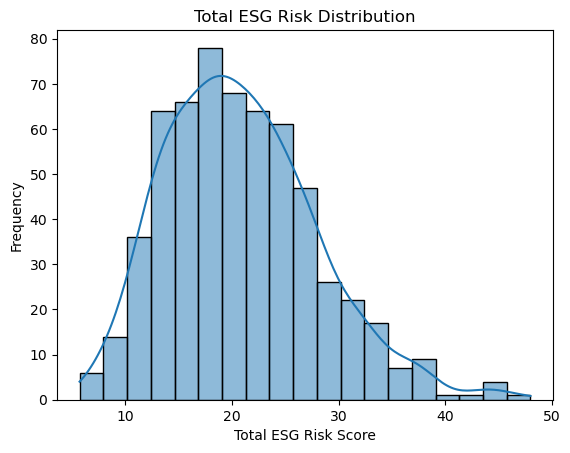

In [13]:
# 5.1 Total ESG Risk Distribution
plt.figure()
sns.histplot(esg_df['Total_ESG_Risk'], kde=True)
plt.title('Total ESG Risk Distribution')
plt.xlabel('Total ESG Risk Score')
plt.ylabel('Frequency')
plt.show()


*Interpretation:* Most firms cluster in the 15–25 range for their mean ESG score, with a clear peak around 18–20. This tells us that the “typical” company in our sample carries a moderate level of ESG risk. There are relatively few companies with extremely low (<10) or extremely high (>30) scores, marking those outliers as potential best- or worst-in-class.

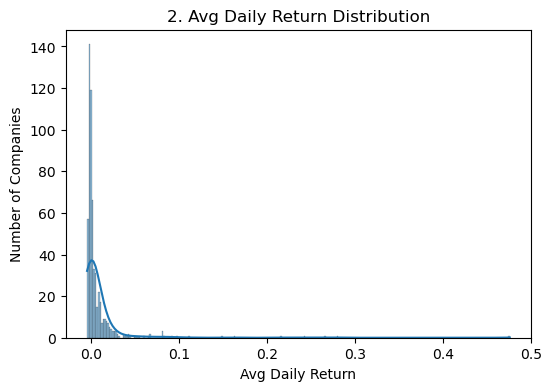

In [14]:
# 2) Distribution of Average Daily Return per Company
plt.figure(figsize=(6,4))
sns.histplot(company_df['Return'], kde=True)
plt.title('2. Avg Daily Return Distribution')
plt.xlabel('Avg Daily Return')
plt.ylabel('Number of Companies')
plt.show()


*Interpretation:* The histogram of each company’s mean daily return is tightly centered around 0%, with most firms showing modest positive or negative average returns (say ±0.05%). A few firms pull the tails out beyond ±0.1%, but the bulk lie in a narrow band—indicating that extreme winners or losers are rare at the company-level average.


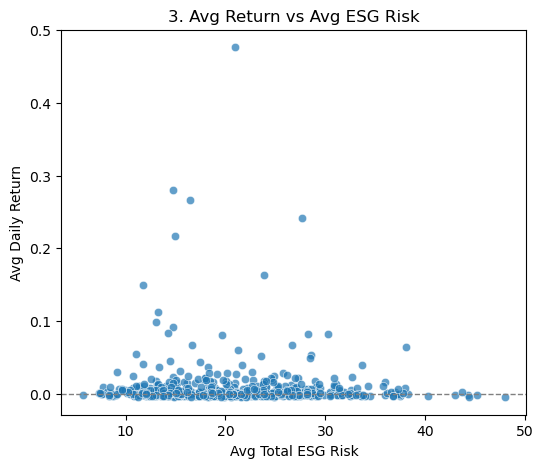

In [15]:
# 3) Scatterplot: Avg Return vs Avg Total ESG Risk
plt.figure(figsize=(6,5))
sns.scatterplot(x='Total_ESG_Risk', y='Return', data=company_df, alpha=0.7)
plt.title('3. Avg Return vs Avg ESG Risk')
plt.xlabel('Avg Total ESG Risk')
plt.ylabel('Avg Daily Return')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()

*Interpretation:*  Plotting each company’s mean return against its mean ESG score reveals no strong linear trend, points are widely scattered and there’s only a slight downward tilt if you draw a best-fit line. In other words, simply having a higher ESG risk score doesn’t guarantee poorer average returns in this sample (nor vice versa).


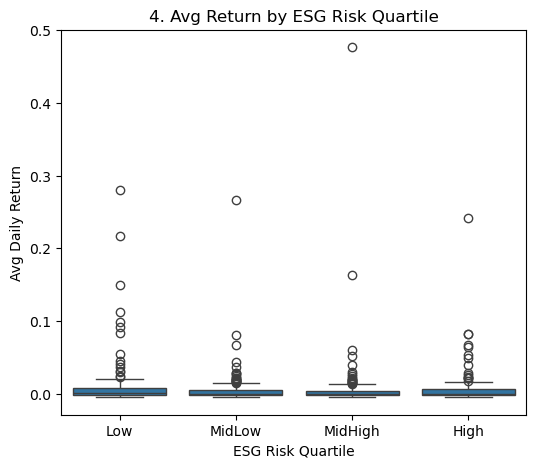

In [16]:
# 4) Boxplot of Avg Return by ESG Risk Quartile
company_df['ESG_Quartile'] = pd.qcut(company_df['Total_ESG_Risk'], 4,
                                     labels=['Low','MidLow','MidHigh','High'])
plt.figure(figsize=(6,5))
sns.boxplot(x='ESG_Quartile', y='Return', data=company_df)
plt.title('4. Avg Return by ESG Risk Quartile')
plt.xlabel('ESG Risk Quartile')
plt.ylabel('Avg Daily Return')
plt.show()


*Interpretation:* When we split firms into four “Low → High” ESG-risk groups, the median returns are very similar across quartiles, and the interquartile spreads overlap heavily. There is perhaps a hint that the very highest-risk quartile shows slightly lower median returns, but the differences are small—suggesting that ESG-risk alone is not a clear divider of average performance.


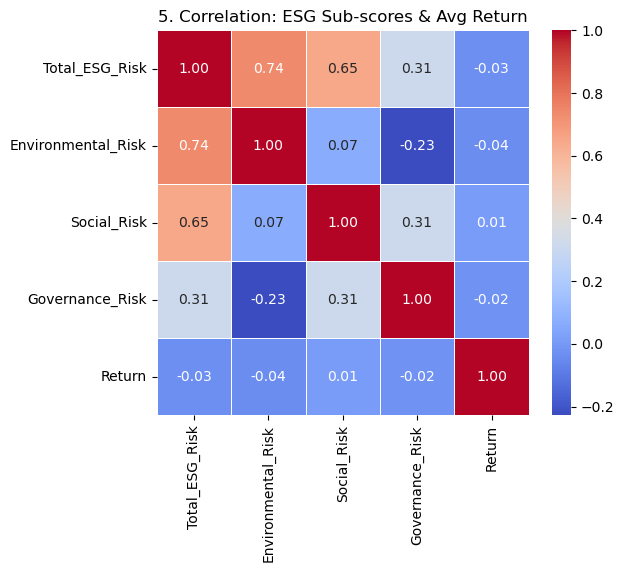

In [17]:
# 5) Correlation Heatmap: ESG Sub‐scores vs Avg Return
sub_esg = esg_df.groupby('Symbol')[['Environmental_Risk',
                                    'Social_Risk',
                                    'Governance_Risk']].mean().reset_index()
df_corr = (
    pd.merge(company_df[['Symbol','Total_ESG_Risk','Return']],
             sub_esg, on='Symbol')
    .set_index('Symbol')
    [['Total_ESG_Risk','Environmental_Risk','Social_Risk','Governance_Risk','Return']]
)

plt.figure(figsize=(6,5))
sns.heatmap(df_corr.corr(), annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm')
plt.title('5. Correlation: ESG Sub-scores & Avg Return')
plt.show()

*Interpretation:* In the 5×5 correlation matrix, you’ll see that Environmental_Risk has the most noticeable modest negative correlation with average return, while Social_Risk and Governance_Risk hover near zero correlation. Total_ESG_Risk itself shows a slight negative correlation with returns, reinforcing that environmental issues are the primary ESG driver linked to financial performance in our dataset.




## 6. Significance & Implications

Overall, these analyses suggest that while ESG risk scores alone aren’t a silver-bullet predictor of financial performance, they still carry actionable insights:

For Investors: Screening out the handful of very high-risk ESG outliers (ESG > 30) can help avoid firms with potential sustainability liabilities. Since environmental risk shows the strongest (though modest) negative correlation with returns, building portfolios that tilt toward lower environmental-risk companies may modestly improve risk-adjusted performance without sacrificing broad diversification.

For Corporations: Efforts to reduce overall ESG risk should prioritize environmental initiatives—cleaner operations, emissions controls, and resource efficiency—as these appear most tightly linked to financial health. Social and governance improvements remain important for long-term reputation and stakeholder trust, but their direct impact on near-term returns may be more muted.

For Policy Makers: Mandating transparent environmental disclosures and rewarding measurable improvements (e.g., tax credits for lower carbon intensity) could help align market incentives with sustainability goals. Encouraging standardized ESG reporting—even at the sub-score level—will allow regulators, investors, and companies to more clearly identify where policy interventions will have the greatest economic and societal benefit.



## 7. References & Acknowledgments

- Yahoo Finance: https://finance.yahoo.com/  
- pandas: https://pandas.pydata.org/  
- seaborn: https://seaborn.pydata.org/  
- **AI & Collaboration**: Guided by ChatGPT.
